# POC Faces de Lote

Para estudar o método foi selecionada uma pequena área para poder testar um método para indetificar e associar cada face do lote ao seu respectivo viário

In [47]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import nearest_points

## Abrindo as camadas de lotes e logradouros

In [48]:
gdf_lotes = gpd.read_file('download/poc-teste-faces-lote.gpkg', driver='GPKG', layer='lotes')
gdf_vias = gpd.read_file('download/poc-teste-faces-lote.gpkg', driver='GPKG', layer='logradouros')

## Trabalhando apenas as faces externas da quadra

Para trabalhar apenas com as faces externas da quadra. Para isso vamos dissolver as geometrias dos lotes e então trabalhar apenas com os segmentos da borda exterior

<AxesSubplot:>

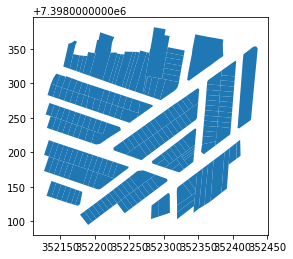

In [49]:
gdf_lotes.plot()

<AxesSubplot:>

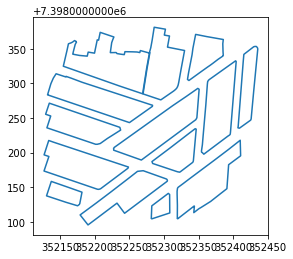

In [50]:
## Observando Buffer de 30cm para dentro do lote para garantir sobreposição
gdf_faces = gdf_lotes.dissolve(by=['lo_quadra', 'lo_setor']).buffer(-.30).boundary
gdf_faces.plot()

## Obter o centroide de cada segmento de linha

Agora é possível obter o centroide de cada segumento de linha, que é com bastante certeza um ponto dentro de um lote

In [51]:
gdf_faces = gpd.GeoDataFrame(geometry=gdf_faces).reset_index().explode()

In [52]:
def centroide_por_segmento(linha):
    segmentos = list(map(LineString, zip(linha.coords[:-1], linha.coords[1:])))
    centroides = list(map(lambda x: x.centroid, segmentos))
    return MultiPoint(centroides)

# gdf_faces.geometry.apply(lambda x: centroide_por_segmento(x))
gdf_pontos_faces = gpd.GeoDataFrame(geometry=gdf_faces.geometry.apply(lambda x: centroide_por_segmento(x)))

In [53]:
gdf_pontos_faces.reset_index().explode()

level_0  level_1                        geometry
0  0         0        0  POINT (352382.086 7398337.386)
   1         0        0  POINT (352378.321 7398334.834)
   2         0        0  POINT (352374.544 7398331.954)
   3         0        0  POINT (352368.518 7398327.427)
   4         0        0  POINT (352364.813 7398324.797)
...        ...      ...                             ...
13 60       12        0  POINT (352196.327 7398099.920)
   61       12        0  POINT (352193.147 7398097.552)
   62       12        0  POINT (352184.536 7398102.612)
   63       12        0  POINT (352181.854 7398112.068)
   64       12        0  POINT (352187.903 7398116.534)

[812 rows x 3 columns]

## Relacionando os pontos aos lotes


In [54]:
gdf_pontos_lotes = gpd.sjoin(gdf_pontos_faces.reset_index().explode(), gdf_lotes)

In [55]:
gdf_pontos_lotes

level_0  level_1                        geometry  index_right lo_setor  \
0  0         0        0  POINT (352382.086 7398337.386)           34      140   
   1         0        0  POINT (352378.321 7398334.834)           34      140   
   2         0        0  POINT (352374.544 7398331.954)           34      140   
   3         0        0  POINT (352368.518 7398327.427)           34      140   
   4         0        0  POINT (352364.813 7398324.797)           34      140   
...        ...      ...                             ...          ...      ...   
13 60       12        0  POINT (352196.327 7398099.920)          158      140   
   64       12        0  POINT (352187.903 7398116.534)          158      140   
   61       12        0  POINT (352193.147 7398097.552)          172      140   
   62       12        0  POINT (352184.536 7398102.612)          172      140   
   63       12        0  POINT (352181.854 7398112.068)          172      140   

      lo_quadra lo_lote lo_condomi lo_tp_quad lo_tp_lote  
0  0        240    0060         00          F          F  
   1        240    0060         00          F          F  
   2        240    0060         00          F          F  
   3        240    0060         00          F          F  
   4        240    0060         00          F          F  
...         ...     ...        ...        ...        ...  
13 60       404    0028         00          F          F  
   64       404    0028         00          F          F  
   61       404    0029         00          F          F  
   62       404    0029         00          F          F  
   63       404    0029         00          F          F  

[812 rows x 10 columns]

## Conectando os pontos ao eixo viário



<AxesSubplot:>

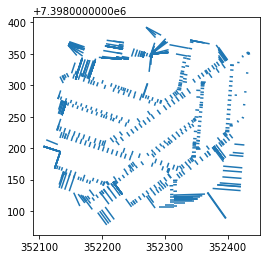

In [56]:
gdf_conexoes = gpd.GeoDataFrame(gdf_pontos_lotes, geometry=gdf_pontos_lotes.geometry.apply(lambda x: LineString(nearest_points(x, gdf_vias.unary_union))))
gdf_conexoes.plot()

## Relacionando as linhas aos lotes e ao viário

In [57]:
gdf_vias_buffered = gpd.GeoDataFrame(gdf_vias, geometry=gdf_vias.buffer(0.5))

In [58]:
gdf_conexoes_relacionadas = gpd.sjoin(gdf_conexoes.drop(columns=['index_right']), gdf_vias_buffered, how='left', op='intersects')

In [59]:
gdf_conexoes_relacionadas

level_0  level_1                                           geometry  \
0  0         0        0  LINESTRING (352382.086 7398337.386, 352386.677...   
   1         0        0  LINESTRING (352378.321 7398334.834, 352382.982...   
   2         0        0  LINESTRING (352374.544 7398331.954, 352378.966...   
   3         0        0  LINESTRING (352368.518 7398327.427, 352372.768...   
   4         0        0  LINESTRING (352364.813 7398324.797, 352369.028...   
...        ...      ...                                                ...   
13 60       12        0  LINESTRING (352196.327 7398099.920, 352210.664...   
   64       12        0  LINESTRING (352187.903 7398116.534, 352184.175...   
   61       12        0  LINESTRING (352193.147 7398097.552, 352207.462...   
   62       12        0  LINESTRING (352184.536 7398102.612, 352175.340...   
   63       12        0  LINESTRING (352181.854 7398112.068, 352178.147...   

      lo_setor lo_quadra lo_lote lo_condomi lo_tp_quad lo_tp_lote  \
0  0       140       240    0060         00          F          F   
   1       140       240    0060         00          F          F   
   2       140       240    0060         00          F          F   
   3       140       240    0060         00          F          F   
   4       140       240    0060         00          F          F   
...        ...       ...     ...        ...        ...        ...   
13 60      140       404    0028         00          F          F   
   64      140       404    0028         00          F          F   
   61      140       404    0029         00          F          F   
   62      140       404    0029         00          F          F   
   63      140       404    0029         00          F          F   

       index_right  ... lg_or_deno lg_ind_ofi lg_ini_par lg_fim_par  \
0  0            24  ...       None    OFICIAL        186        250   
   1            24  ...       None    OFICIAL        186        250   
   2            24  ...       None    OFICIAL        186        250   
   3            24  ...       None    OFICIAL        186        250   
   4            24  ...       None    OFICIAL        186        250   
...            ...  ...        ...        ...        ...        ...   
13 60           16  ...       None    OFICIAL        146        296   
   64           48  ...       None    OFICIAL        184        320   
   61           16  ...       None    OFICIAL        146        296   
   62           48  ...       None    OFICIAL        184        320   
   63           48  ...       None    OFICIAL        184        320   

      lg_ini_imp lg_fim_imp lg_ordem    lg_id  lg_seg_id  lg_or_geom  
0  0         187        251        5  44329.0       9653        None  
   1         187        251        5  44329.0       9653        None  
   2         187        251        5  44329.0       9653        None  
   3         187        251        5  44329.0       9653        None  
   4         187        251        5  44329.0       9653        None  
...          ...        ...      ...      ...        ...         ...  
13 60        147        297        5  37119.0       3371        None  
   64        185        321        3  53753.0      10205        None  
   61        147        297        5  37119.0       3371        None  
   62        185        321        3  53753.0      10205        None  
   63        185        321        3  53753.0      10205        None  

[820 rows x 25 columns]

## Resultados

Dessa forma então é possivel determinar para quantas e quais vias cada lote se relaciona restando ainda por processar a geometria de cada uma das faces se for conveniente

In [60]:
gdf_conexoes_relacionadas.lg_seg_id.values

array([ 9653,  9653,  9653,  9653,  9653,  9653,  9653,  9654,  9654,
       10679, 10679, 10679, 10679, 10679, 10679, 10679, 10679, 10679,
       10679, 10679, 10679, 10679,  9653,  9653,  9653,  9653,  9653,
        9653,  9653,  9653, 10250, 10250, 10250, 10250, 10250, 10250,
       10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250,
       10250, 11421,  8739, 11421, 11422, 11422, 11422, 10250, 10250,
       10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250,
       10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250, 10250,
       10561, 10250, 10250, 10561,  9646, 10250, 10250, 10561, 10561,
       10561, 11494, 11494, 11494,  9646, 10561, 10561, 10561, 10561,
       10561, 10561, 10561, 10561, 10561, 10561, 10561, 10561, 10561,
       11494, 11494, 11494, 11494, 10561, 10561, 10561, 11493, 10561,
        8681, 10560, 11493, 11493,  3371,  3371,  3371, 10250,  3371,
        3371,  3371,  3371,  3371, 10250, 10250, 10250, 10250, 10250,
       10250, 10250,

<AxesSubplot:>

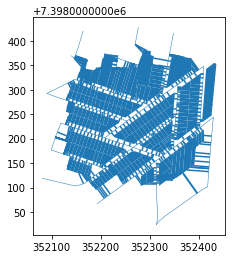

In [61]:
ax = gdf_lotes.plot()
gdf_vias[gdf_vias.lg_seg_id.isin(gdf_conexoes_relacionadas.lg_seg_id.values)].plot(ax=ax)
gdf_conexoes.plot(ax=ax)

In [68]:
gdf_conexoes_relacionadas.drop(columns=['level_0', 'level_1'])

geometry lo_setor lo_quadra  \
0  0   LINESTRING (352382.086 7398337.386, 352386.677...      140       240   
   1   LINESTRING (352378.321 7398334.834, 352382.982...      140       240   
   2   LINESTRING (352374.544 7398331.954, 352378.966...      140       240   
   3   LINESTRING (352368.518 7398327.427, 352372.768...      140       240   
   4   LINESTRING (352364.813 7398324.797, 352369.028...      140       240   
...                                                  ...      ...       ...   
13 60  LINESTRING (352196.327 7398099.920, 352210.664...      140       404   
   64  LINESTRING (352187.903 7398116.534, 352184.175...      140       404   
   61  LINESTRING (352193.147 7398097.552, 352207.462...      140       404   
   62  LINESTRING (352184.536 7398102.612, 352175.340...      140       404   
   63  LINESTRING (352181.854 7398112.068, 352178.147...      140       404   

      lo_lote lo_condomi lo_tp_quad lo_tp_lote  index_right lg_codlog lg_tipo  \
0  0     0060         00          F          F           24    145688       R   
   1     0060         00          F          F           24    145688       R   
   2     0060         00          F          F           24    145688       R   
   3     0060         00          F          F           24    145688       R   
   4     0060         00          F          F           24    145688       R   
...       ...        ...        ...        ...          ...       ...     ...   
13 60    0028         00          F          F           16    074462       R   
   64    0028         00          F          F           48    239143       R   
   61    0029         00          F          F           16    074462       R   
   62    0029         00          F          F           48    239143       R   
   63    0029         00          F          F           48    239143       R   

       ... lg_or_deno lg_ind_ofi lg_ini_par lg_fim_par lg_ini_imp  lg_fim_imp  \
0  0   ...       None    OFICIAL        186        250        187         251   
   1   ...       None    OFICIAL        186        250        187         251   
   2   ...       None    OFICIAL        186        250        187         251   
   3   ...       None    OFICIAL        186        250        187         251   
   4   ...       None    OFICIAL        186        250        187         251   
...    ...        ...        ...        ...        ...        ...         ...   
13 60  ...       None    OFICIAL        146        296        147         297   
   64  ...       None    OFICIAL        184        320        185         321   
   61  ...       None    OFICIAL        146        296        147         297   
   62  ...       None    OFICIAL        184        320        185         321   
   63  ...       None    OFICIAL        184        320        185         321   

       lg_ordem    lg_id  lg_seg_id  lg_or_geom  
0  0          5  44329.0       9653        None  
   1          5  44329.0       9653        None  
   2          5  44329.0       9653        None  
   3          5  44329.0       9653        None  
   4          5  44329.0       9653        None  
...         ...      ...        ...         ...  
13 60         5  37119.0       3371        None  
   64         3  53753.0      10205        None  
   61         5  37119.0       3371        None  
   62         3  53753.0      10205        None  
   63         3  53753.0      10205        None  

[820 rows x 23 columns]

In [69]:
gdf_conexoes_relacionadas.drop(columns=['level_0', 'level_1']).to_file('resultados/conexoes_relacionadas_viario_lote.gpkg', driver='GPKG')